In [ ]:
!pip install torchinfo
!pip install medmnist
import torch
from torch import nn
from torch import nn, einsum
import torch.nn.functional as F
from torch import optim
from torch.utils.data import DataLoader

import numpy as np
import torchvision
import time
from torchinfo import summary
from torchvision import datasets, transforms
import torch
from torch import nn
from torch import nn, einsum
import torch.nn.functional as F
from torch import optim

from einops import rearrange, repeat
from einops.layers.torch import Rearrange
import numpy as np
import torchvision
import time
from torchinfo import summary
from medmnist import PneumoniaMNIST

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 47.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 35.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 38.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 56.5 MB/s eta 0:00:00
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114249 sha256=

# Model


In [ ]:
def scaled_dot_product(V,Q,K,Fk,mask = None) :
  C = torch.matmul(Q,K.transpose(-2,-1))/ torch.sqrt(torch.tensor(Fk, dtype=torch.float32))
  if mask is not None:
      scores = scores.masked_fill(mask == 0, float('-1e9'))
  C = nn.Softmax(dim=-1)(C)
  return torch.matmul(C,V)

class NewAttention(nn.Module):
    def __init__(self, Fv, Fk, Fv_o, Fk_o, heads,F_out, drop_out = 0.1,final_linear = True):
        super(NewAttention, self).__init__()
        self.Fv = Fv
        self.Fk = Fk
        self.Fv_o = Fv_o
        self.Fk_o = Fk_o
        self.heads = heads
        self.head_linearV = nn.Linear(self.Fv,self.Fv_o* self.heads)
        self.head_linearK = nn.Linear(self.Fk,self.Fk_o* self.heads)
        self.head_linearQ = nn.Linear(self.Fk,self.Fk_o* self.heads)
        self.final_linear = nn.Linear(heads * Fv_o, F_out)
        self.droput = nn.Dropout(drop_out)
    def forward(self, V, K, Q, mask=None):
        # V, K, Q: [batch, seq_len, dim]
        batch, seq_len, _ = V.shape
        v = self.head_linearV(V)
        k = self.head_linearK(K)
        q = self.head_linearQ(Q) ### [N,S,F_v] -> [N,S,Fv_o*heads]

        v = v.reshape(batch,seq_len, self.heads,self.Fv_o).transpose(1, 2) #[N,S,Fv_o*heads]  -> [N,S,heads,Fv_o] -> [N,heads,S,Fv_o]
        k = k.reshape(batch,seq_len, self.heads,self.Fk_o).transpose(1, 2)
        q = q.reshape(batch, seq_len, self.heads, self.Fk_o).transpose(1, 2)

        attn = scaled_dot_product(v, q, k, self.Fk_o,mask) # [batch, heads, seq_len, Fv_o]
        attn = attn.transpose(1,2).reshape(batch,seq_len, self.heads * self.Fv_o) # [batch, seq_len, Fv_o * heads]
        result = self.final_linear(attn.reshape(batch,seq_len, self.heads * self.Fv_o))
        return result


class FF (nn.Module):
    def __init__(self, F_in,F_o,dropout_rate = 0.1):
        super(FF, self).__init__()
        self.linear1 = nn.Linear(F_in,F_o)
        self.linear2 = nn.Linear(F_o,F_in)
        self.dropout = nn.Dropout(dropout_rate)
        self.act = nn.ReLU()

    def forward(self, x):
        x = self.linear1(x) # [...,F_in] -> [...,F_o]
        x = self.act(x)
        x = self.dropout(x)
        x = self.linear2(x) #[...,F_o] -> [...,F_in]
        return x

class Transformer(nn.Module):
    def __init__(self, F_in,F_o,mlp_dim,heads,dropout_rate = 0.1):
      # self.
      super(Transformer, self).__init__()
      self.attn_norm = nn.LayerNorm(F_in, eps=1e-6)
      self.norm = nn.LayerNorm(F_in, eps=1e-6)
      self.ff = FF(F_in,mlp_dim,dropout_rate)
      self.attention = NewAttention(F_in,F_in,F_o,F_o,heads,F_in)
      # self.attention = NewAttention(F_in,heads)
    def forward(self,x,mask = None):
      residue = x
      x = self.attn_norm(x)
      x = self.attention(x,x,x)
      # x = self.attention(x)
      x = x + residue
      residue = x
      x = self.norm(x)
      x = self.ff(x)
      x = x + residue
      return x

class VIT(nn.Module) :
  def __init__(self,channel,image_h, image_w, patch, F_in,F_o,F_out, heads,trans_depth,mlp_dim, mode = "average"):
    super(VIT, self).__init__()
    assert image_h % patch == 0, "Image height must be divisible by the patch size."
    assert image_w % patch == 0, "Image width must be divisible by the patch size."
    self.channel = channel
    self.image_h = image_h
    self.image_w = image_w
    self.patch = patch
    self.num_patch_h = image_h // patch
    self.num_patch_w = image_w // patch
    self.num_patch = self.num_patch_h * self.num_patch_w
    self.mode = mode

    patch_dim = channel * patch * patch
    self.patch_linear = nn.Linear(patch_dim, F_in)
    self.trans_layers = nn.ModuleList([Transformer(F_in,F_o,mlp_dim,heads) for i in range(trans_depth)])

    self.pos_embedding = nn.Parameter(torch.randn(1, self.num_patch + 1, F_in)) ## positional embedding

    self.cls_token = nn.Parameter(torch.randn(1, 1, F_in)) ### classfication token for prediction
    self.dropout = nn.Dropout(0.1)
    self.norm = nn.LayerNorm(F_in, eps=1e-6)
    self.final_linear  = nn.Linear(F_in,F_out)

  def forward(self,x,mask = None):
    b, c, h, w = x.shape
    x = x.reshape(b, c, self.num_patch_h, self.patch, self.num_patch_w, self.patch)
    x = x.permute(0, 2, 4, 1, 3, 5)  # [b, num_patch_h, num_patch_w, c, patch, patch]
    x = x.reshape(b, self.num_patch, c * self.patch * self.patch)  # [b, num_patch, patch_dim]
    x = self.patch_linear(x) ### -> [B,N,F_in]
    cls_tokens = self.cls_token.repeat(b, 1, 1) ### [B,1,F_in]
    x = torch.cat([cls_tokens, x], dim=1)
    x += self.pos_embedding ## [B,N+1,F_in]
    x = self.dropout(x)
    for layer in self.trans_layers:
      x = layer(x)   #### transformer block
    x = self.norm(x)
    x = self.final_linear(x)
    if self.mode == "average":
      return x.mean(dim = 1)
    else : return x[:,0,:]


# Documentation, Model Analysis and  Code Efficiency Analysis
This implementation follow the same principle to ViT model, with my own implementation on the attention module (not using the original pytorch SelfAttention Module) to provide flexibility like the original [Attention is all you need](https://arxiv.org/abs/1706.03762)
See [MultiheadAttetion](https://pytorch.org/docs/stable/generated/torch.nn.MultiheadAttention.html) for the differences.

**Here is how my attention module, FeadForward network,a transformer block and the original ViT module visualized respectively**

# **Figure 1:Attention module**

**In:  B,N,F_in -> out B,N,F_in with the intermidiate shape is B,N,F_o**

**Time complexity:**

For Scaled-dot Product: O(B * N^2 * F_o) with F_O is the last dimension of V-K-Q (main computation is the matrix computation)

For the 3 linear transform : O(B * N * F_In * F_out)

For the last linear transform: O(B * N * F_out * F_in)

-> in our works, it will be dominated by O(B * N * F_out * F_in)


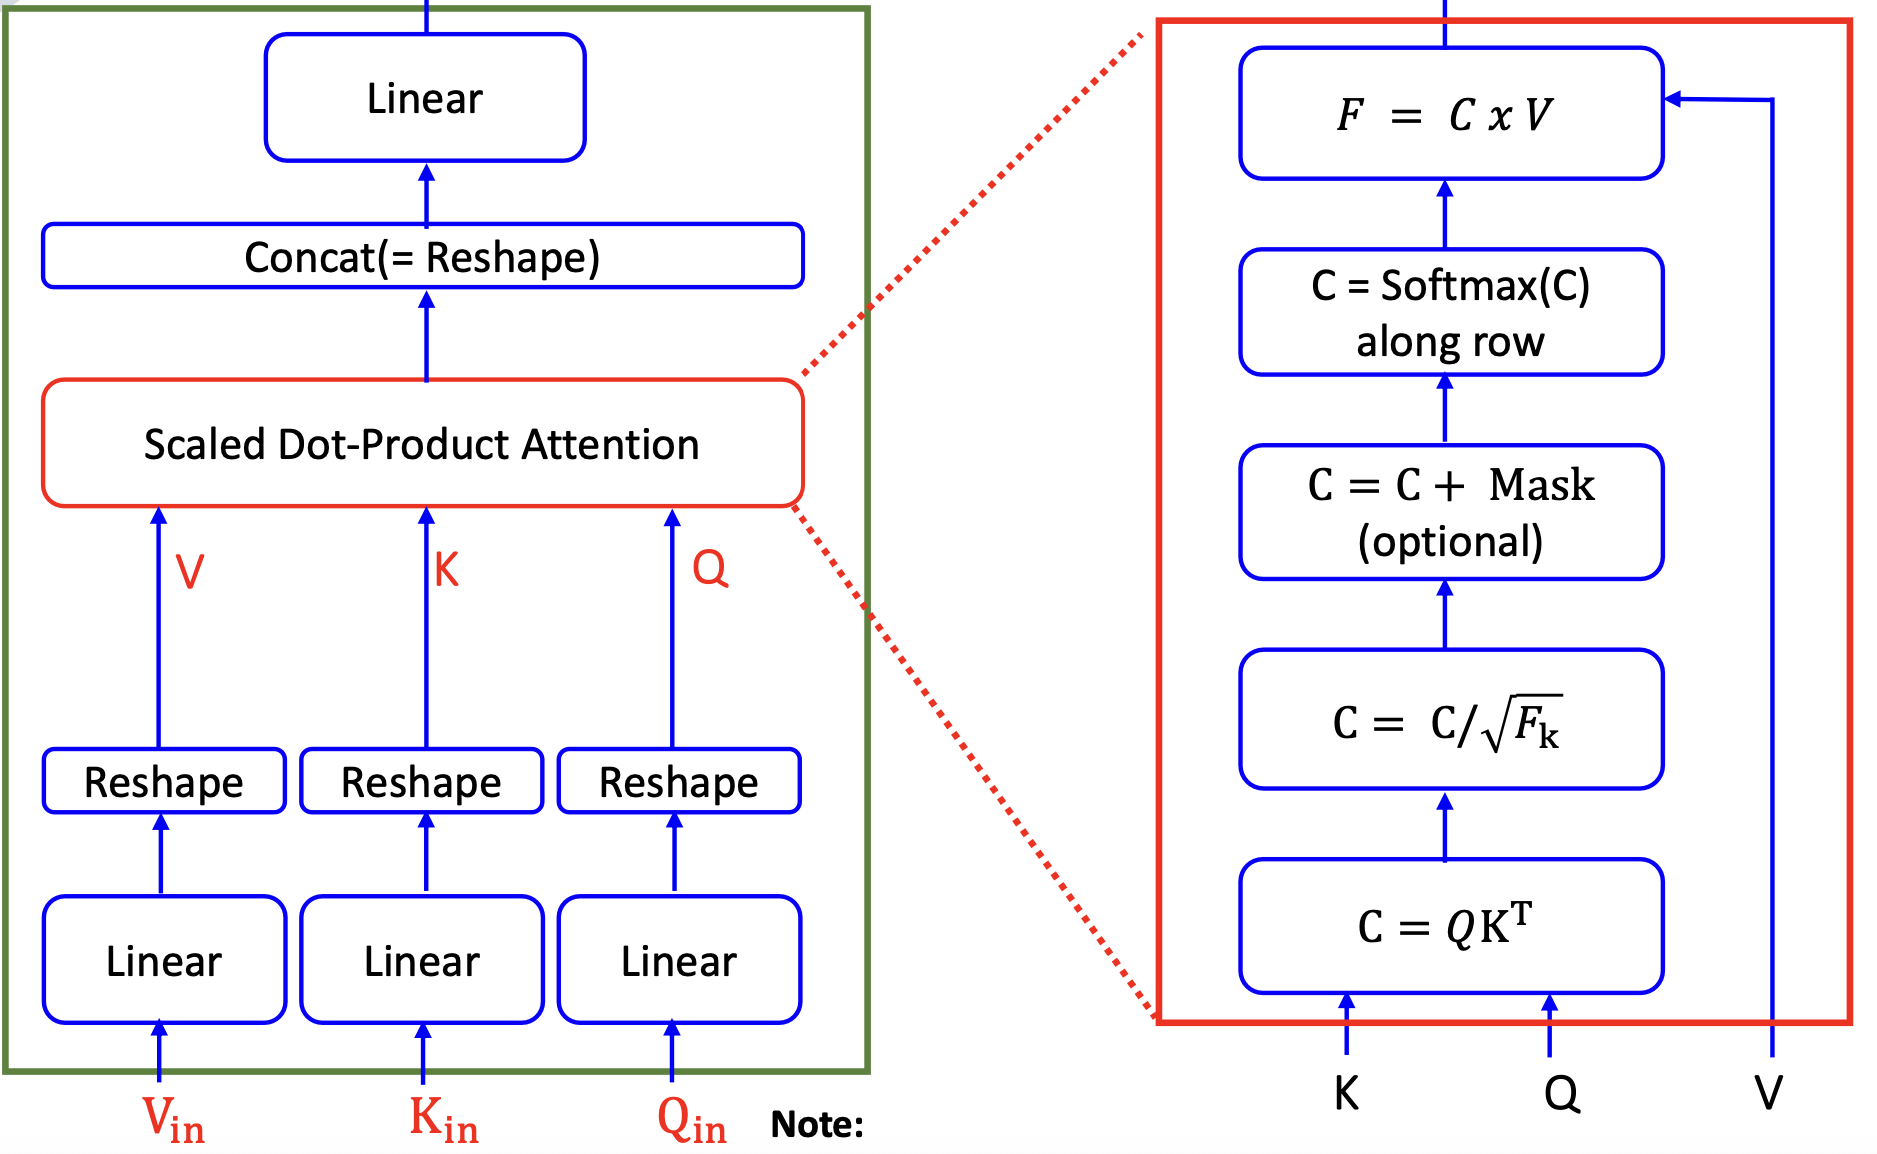

# **Figure 2: Fead forward network**

(The linear Block in the Figure 3)

**In: B,N,F_in -> Out: B,N,F_in**

**Time complexity:**

O(B * N * F_in)


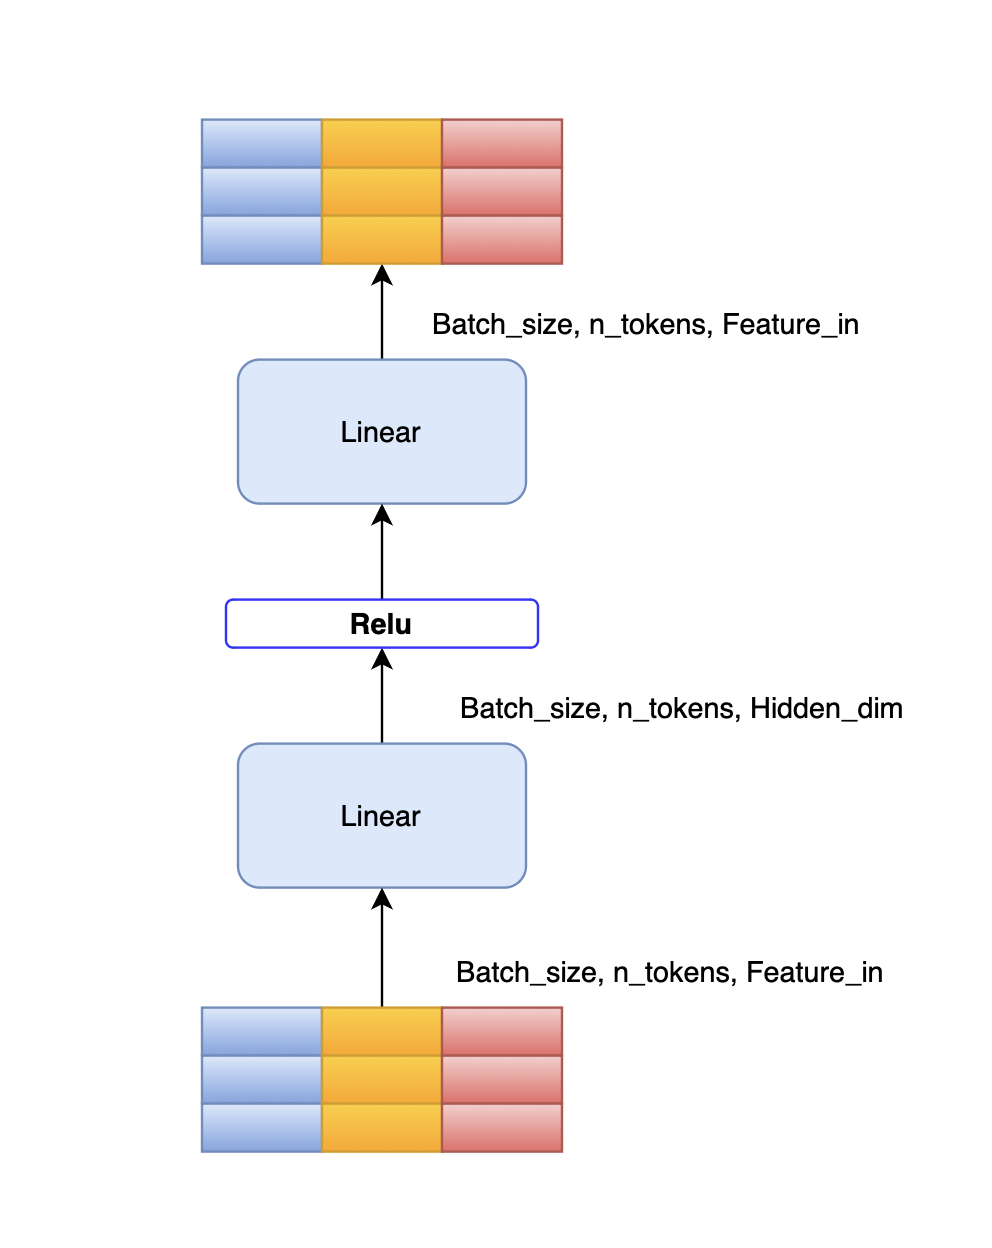

# **Figure 3: A transformer block**

**In: B,N,F_in -> Out: B,N,F_in**

**The time complexity** shall be dominated by the attention block (O(B * N * F_out * F_in))
and with d transformer block
-> the final **time complexity** is (O(B * N * F_out * F_in * d))

**Space complexity:**

With Linear transform only: O(F_in * F_out), but for the scaleddot_matrix: O(B * N^2) -> it depends on the value F_in,F_out and N,B but in our work it's O(F_in,F_out)

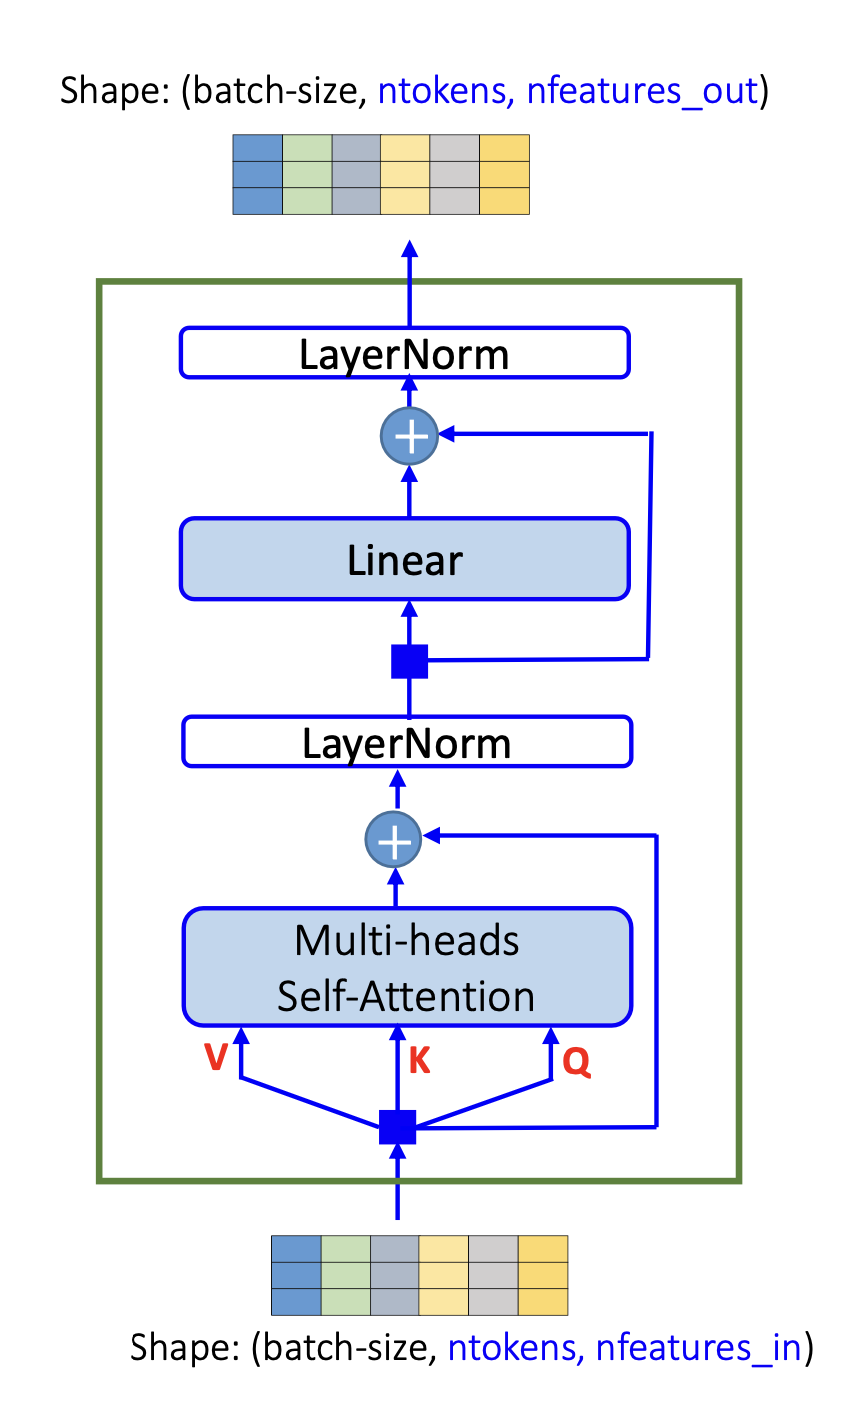

# **Figure 4: ViT model**


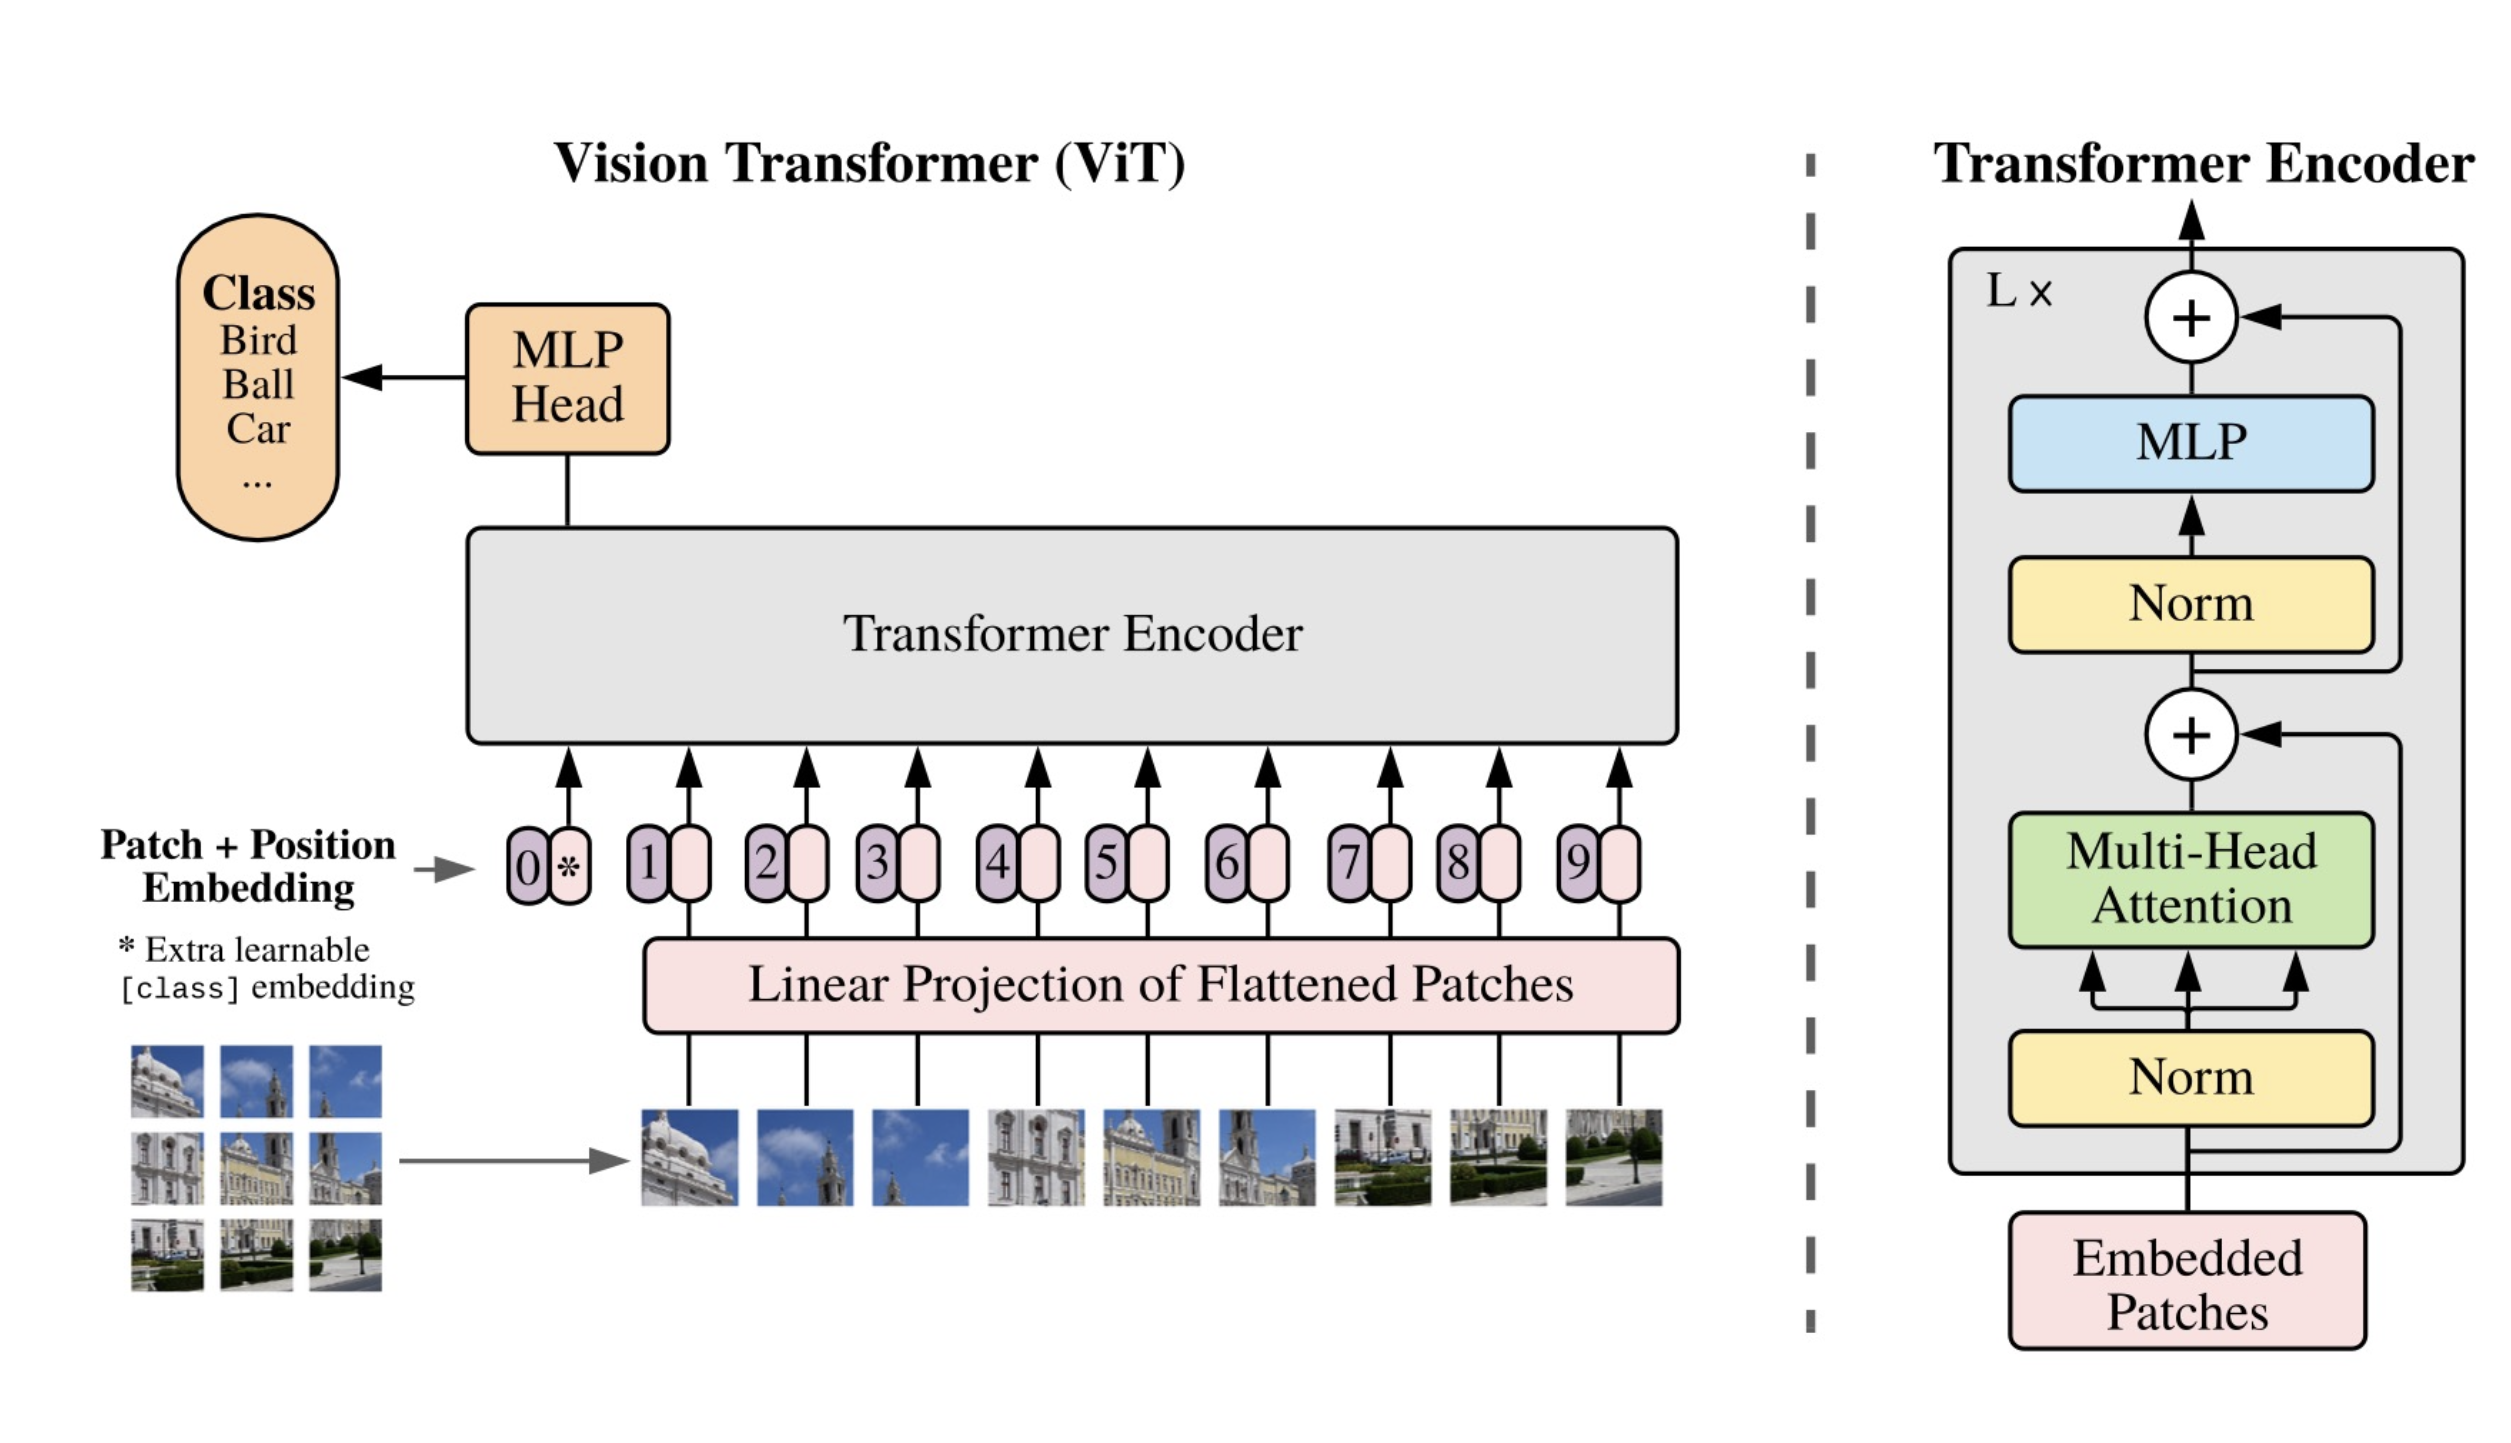

For the correctness of the model, please refer to [this](https://github.com/shub-garg/Vision-Transformer-VIT-for-MNIST/blob/main/Vision_Transformer_for_MNIST.ipynb) notebook. I implement the same architecture, with some minor change with the usage of helper function/library, and a

# Data preprocessing
Compute the mean and standard deviation  over the MedMNIST data and normalize the data

In [ ]:

def compute_mean_std(dataset):
    loader = DataLoader(dataset, batch_size=500, shuffle=False, num_workers=2)
    mean = 0.0
    std = 0.0
    total_samples = 0

    for images, _ in loader:
        batch_samples = images.size(0)  # batch size (number of images in a batch)
        images = images.view(batch_samples, -1)  # Flatten to (batch_size, H*W)

        mean += images.mean(dim=1).sum().item()
        std += images.std(dim=1).sum().item()
        total_samples += batch_samples

    mean /= total_samples
    std /= total_samples
    return mean, std

# Load dataset without transform
raw_dataset = PneumoniaMNIST(split='train', download=True, transform=transforms.ToTensor())
mean, std = compute_mean_std(raw_dataset)
print(mean,std)

Using downloaded and verified file: /root/.medmnist/pneumoniamnist.npz
0.5719215730133964 0.14478424432020423


In [ ]:

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[mean], std=[std])
])
train_dataset = PneumoniaMNIST(split='train', download=True, transform=transform)
test_set = PneumoniaMNIST(split='test', download=True, transform=transform)

data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=100, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=1000, shuffle=True)
test = iter(data_loader)
test = next(test)
data = test[0]
C = data.shape[1]
H = data.shape[2]
W = data.shape[3]
print(C,H,W)

Using downloaded and verified file: /root/.medmnist/pneumoniamnist.npz
Using downloaded and verified file: /root/.medmnist/pneumoniamnist.npz
1 28 28


# Hyperparameter tuning and code

mlp_dim is the dimension of the feed forward network inbetween each transformer block, i decide for it to be twice as much as the F_in.
**Please note that the out dimension of each transformer block is F_in (64) because there is a residual block so the last dimension have to be equal**


In [ ]:
classes = np.unique(train_dataset.labels)
print(classes)
targets = train_dataset.labels
channel = C
image_h  = H
image_w = W
patch = 4 ## 28%4 == 0
F_out = len(classes) ## num_class
F_o = 64
heads = 4
F_in = 64
mlp_dim = 128
trans_depth = 6
model = VIT( channel,image_h, image_w, patch,F_in,F_o, F_out,heads,trans_depth,mlp_dim,mode = "zero")
optimizer = optim.Adam(model.parameters(), lr=0.003)
out = model(data)
print("Output shape:", out.shape)
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(count_parameters(model))
summary(model)



[0 1]
Output shape: torch.Size([100, 2])
503810


Layer (type:depth-idx)                   Param #
VIT                                      3,264
├─Linear: 1-1                            1,088
├─ModuleList: 1-2                        --
│    └─Transformer: 2-1                  --
│    │    └─LayerNorm: 3-1               128
│    │    └─LayerNorm: 3-2               128
│    │    └─FF: 3-3                      16,576
│    │    └─NewAttention: 3-4            66,368
│    └─Transformer: 2-2                  --
│    │    └─LayerNorm: 3-5               128
│    │    └─LayerNorm: 3-6               128
│    │    └─FF: 3-7                      16,576
│    │    └─NewAttention: 3-8            66,368
│    └─Transformer: 2-3                  --
│    │    └─LayerNorm: 3-9               128
│    │    └─LayerNorm: 3-10              128
│    │    └─FF: 3-11                     16,576
│    │    └─NewAttention: 3-12           66,368
│    └─Transformer: 2-4                  --
│    │    └─LayerNorm: 3-13              128
│    │    └─LayerNorm: 3-14       

For the correctness of the model, please refer to [this](https://github.com/shub-garg/Vision-Transformer-VIT-for-MNIST/blob/main/Vision_Transformer_for_MNIST.ipynb) notebook. I implement the same architecture, with some minor change with the usage of helper function/library, and a

# Helper function


In [ ]:
def train_epoch(model, optimizer, data_loader, loss_history):
    total_samples = len(data_loader.dataset)
    model.train()

    for i, (data, target) in enumerate(data_loader):
        optimizer.zero_grad()
        output = F.log_softmax(model(data), dim=1)
        loss = F.nll_loss(output, target.squeeze(1))
        loss.backward()
        optimizer.step()


        if i % 100 == 0:
            print('[' +  '{:5}'.format(i * len(data)) + '/' + '{:5}'.format(total_samples) +
                  ' (' + '{:3.0f}'.format(100 * i / len(data_loader)) + '%)]  Loss: ' +
                  '{:6.4f}'.format(loss.item()))
            loss_history.append(loss.item())
def evaluate(model, data_loader, loss_history):
    model.eval()

    total_samples = len(data_loader.dataset)
    correct_samples = 0
    total_loss = 0

    with torch.no_grad():
        for data, target in data_loader:
            output = F.log_softmax(model(data), dim=1)
            loss = F.nll_loss(output, target.squeeze(1), reduction='sum')
            _, pred = torch.max(output, dim=1)

            total_loss += loss.item()
            correct_samples += pred.eq(target.squeeze(1)).sum()

    avg_loss = total_loss / total_samples
    loss_history.append(avg_loss)
    print('\nAverage test loss: ' + '{:.4f}'.format(avg_loss) +
          '  Accuracy:' + '{:5}'.format(correct_samples) + '/' +
          '{:5}'.format(total_samples) + ' (' +
          '{:4.2f}'.format(100.0 * correct_samples / total_samples) + '%)\n')
def train_model(model, train_loader, test_loader, optimizer, criterion, device, epochs=10):
    for epoch in range(epochs):
        print(f'Epoch {epoch + 1}/{epochs}')
        train_epoch(model, train_loader, optimizer, criterion, device)
        evaluate(model, test_loader, criterion, device)
    print('Training Complete!')


# **Training process**

In [ ]:

N_EPOCHS = 10

start_time = time.time()


train_loss_history, test_loss_history = [], []
for epoch in range(1, N_EPOCHS + 1):
    print('Epoch:', epoch)
    train_epoch(model, optimizer, data_loader, train_loss_history)
    evaluate(model, test_loader, test_loss_history)

print('Execution time:', '{:5.2f}'.format(time.time() - start_time), 'seconds')

Epoch: 1
[    0/ 4708 (  0%)]  Loss: 0.7337

Average test loss: 0.4811  Accuracy:  513/  624 (82.21%)

Epoch: 2
[    0/ 4708 (  0%)]  Loss: 0.2473

Average test loss: 0.4912  Accuracy:  516/  624 (82.69%)

Epoch: 3
[    0/ 4708 (  0%)]  Loss: 0.2069

Average test loss: 0.5068  Accuracy:  526/  624 (84.29%)

Epoch: 4
[    0/ 4708 (  0%)]  Loss: 0.1478

Average test loss: 0.2960  Accuracy:  549/  624 (87.98%)

Epoch: 5
[    0/ 4708 (  0%)]  Loss: 0.2142

Average test loss: 0.7029  Accuracy:  457/  624 (73.24%)

Epoch: 6
[    0/ 4708 (  0%)]  Loss: 0.1346

Average test loss: 0.5855  Accuracy:  510/  624 (81.73%)

Epoch: 7
[    0/ 4708 (  0%)]  Loss: 0.1767

Average test loss: 0.5121  Accuracy:  523/  624 (83.81%)

Epoch: 8
[    0/ 4708 (  0%)]  Loss: 0.1279

Average test loss: 0.6244  Accuracy:  496/  624 (79.49%)

Epoch: 9
[    0/ 4708 (  0%)]  Loss: 0.1201

Average test loss: 0.4036  Accuracy:  538/  624 (86.22%)

Epoch: 10
[    0/ 4708 (  0%)]  Loss: 0.1555

Average test loss: 0.4048  

# Testing
For the metric,i use confusion and f1 score.
To visualize f1 score, i decided to use heat map


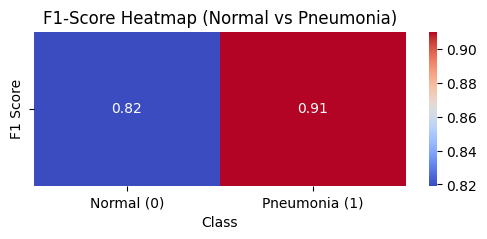

In [ ]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, f1_score

def plot_f1_heatmap(model, data_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for data, target in data_loader:
            output = model(data)
            target = target.squeeze(1)
            _, preds = torch.max(output, dim=1)
            all_preds.extend(preds.numpy())
            all_labels.extend(target.numpy())

    # Compute F1-score for each class
    f1_scores = f1_score(all_labels, all_preds, average=None)

    class_labels = ["Normal (0)", "Pneumonia (1)"]

    # Convert to 2D array for heatmap
    f1_matrix = np.expand_dims(f1_scores, axis=0)

    plt.figure(figsize=(6, 2))
    sns.heatmap(f1_matrix, annot=True, fmt='.2f', cmap='coolwarm', xticklabels=class_labels, yticklabels=['F1 Score'])
    plt.xlabel('Class')
    plt.title('F1-Score Heatmap (Normal vs Pneumonia)')
    plt.show()

# Example usage
plot_f1_heatmap(model, test_loader)

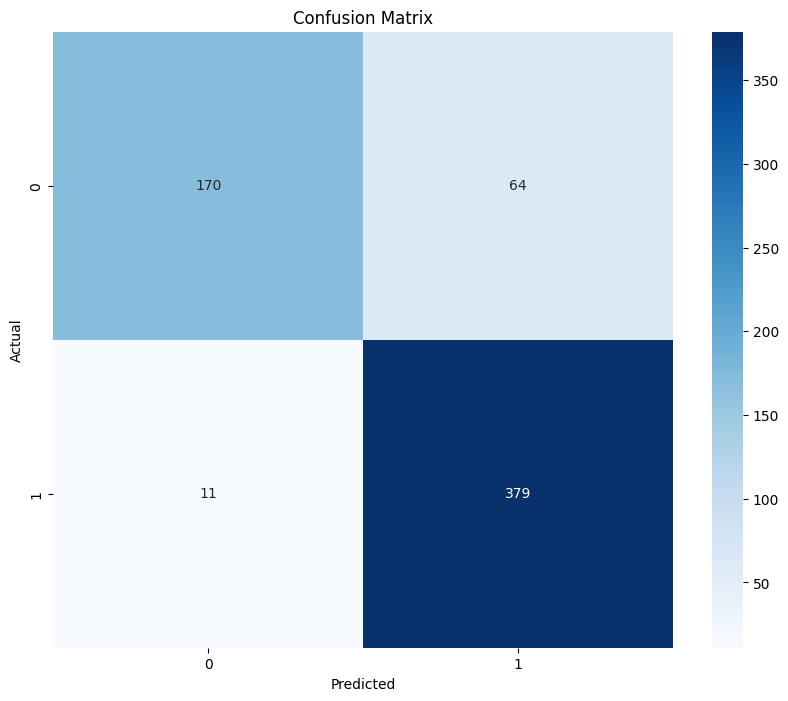

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# Confusion matrix
def plot_confusion_matrix(model, data_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for data, target in data_loader:
            output = model(data)
            target = target.squeeze(1)
            _, preds = torch.max(output, dim=1)
            all_preds.extend(preds.numpy())
            all_labels.extend(target.numpy())

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

plot_confusion_matrix(model, test_loader)

# Final words about the model

Limitation:
- Hyper parameter tuning: in this case i only anagously choose F_in to be 64, and the hidden features is 128 (twice as much). We can't certainly which hyper parameter will give out the best result.
- Large memory or computational requirements


